# CSE 574: Homework 3

### Glenn Thomakos

I certify that the code and data in this assignment were generated independently,
using only the tools and resources defined in the course and that I did not receive
any external help, coaching or contributions during the production of this work.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

## Part 1: Building a Basic NN

#### Step 1: Load, preprocess, and analyze the dataset and make it ready for training.

First, a quick glance at what's going on in the dataset. It's a 32561 x 15 data frame with mostly categorical data. Already we can see some missing values, marked by a "?" in this dataset, so those will have to be sorted out. 

Furthermore, all of the columns are pretty self-explanatory except for "fnlwgt" which, after some investigative googling (https://www.kaggle.com/datasets/uciml/adult-census-income/discussion/32698), seems to be quite the finnicky column so I'll just drop it from the dataset to avoid any complications and assumptions about correlations within the data. 

Speaking of correlations,"education" will be removed since it's just a categorical representation of the "education.num" column. I could have just eliminated "education.num" instead and made a bunch of dummy variables for education but that would have cluttered up the dataset given the large amount of levels in that column.

"Relationship" is eliminated simply since it has very little to do with income (putting the cart before the horse, if there was any correlation) while "race" and "sex" were eliminated in order to avoid biases based on these variables.

In [79]:
df_income = pd.read_csv('income_dataset.csv')

print(df_income.shape)
print(df_income.dtypes)

df_income = df_income.drop(['fnlwgt','education','race','sex','relationship'],axis=1)
print(df_income.describe())
df_income.head()

(32561, 15)
age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object
                age  education.num  capital.gain  capital.loss  hours.per.week
count  32561.000000   32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581647      10.080679   1077.648844     87.303830       40.437456
std       13.640433       2.572720   7385.292085    402.960219       12.347429
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       48.000000      12.000000      0.0000

,age,workclass,education.num,marital.status,occupation,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,9,Widowed,?,0,4356,40,United-States,<=50K
1,82,Private,9,Widowed,Exec-managerial,0,4356,18,United-States,<=50K
2,66,?,10,Widowed,?,0,4356,40,United-States,<=50K
3,54,Private,4,Divorced,Machine-op-inspct,0,3900,40,United-States,<=50K
4,41,Private,10,Separated,Prof-specialty,0,3900,40,United-States,<=50K


Now we need to check in on the amount of NA values that are in the dataset. Due to the small amount of missing values they'll simply be dropped from the dataset in order to yield a new data frame which has 30162 entries which is 92.6% the size of the original.

In [80]:
df_income = df_income.replace(['?'],[None])
print(df_income.isna().sum())
df_income = df_income.dropna()

age                  0
workclass         1836
education.num        0
marital.status       0
occupation        1843
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


From this point, we've got some columns that need some treatment. The changes will be shown for each column in the order they are shown in the print above: 

* age: Will be normalized.

* workclass: Will require dummy variables.

* marital.status: Will require dummy variables.

* occupation: Will require dummy variables.

* relationship: Will require dummy variables.

* race: 'White' overwhelms the other options. Will be swapped to "White" and "Other", then dummy variable.

* capital.gain: Will be normalized.

* capital.loss: Same as capital.gain.

* native.country: There's several levels here, and "United-States" dominates the column, so it's going to be changed to "United-States" and "Other" similarly to the "race" column.

* hours.per.week: Will be binned into 3 categories: 'PartTime', 'FullTime', and 'Workaholic'.

* income: Will require dummy variables.

I'm not overly fond of the amount of dummy variables here as it's going to create quite a few columns and the dataset will be wildly unpleasant to look at. However, from this point on we really don't need to look at the raw data and if it helps make a model, I'm prepared to have an ugly dataset.

This graph below is an illustration of the problematic nature of the "native.country" column. The United States is very clearly overrepresented by quite the wide margin. Furthermore, there's a bunch of other countries that are accounted for in this dataset that even when rotating the labels, it's still quite crowded on the x-axis.

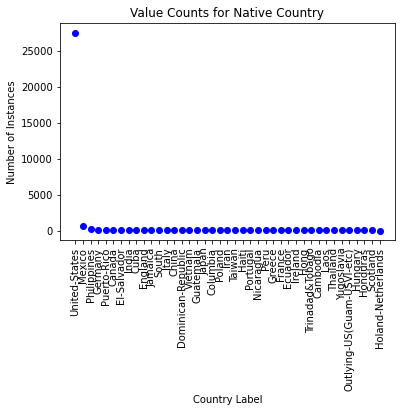

In [81]:
plt.plot(df_income['native.country'].value_counts(),'bo')
plt.title('Value Counts for Native Country')
plt.xlabel('Country Label')
plt.ylabel('Number of Instances')
plt.xticks(rotation=90)
plt.show()

This plot below evaluates how important education is when determining our target variable of income. We can clearly see that most people in the dataset have an education level of between 9 and 13 (high school grad and bachelor's degree respectively, but the peaks in the two densities of income are centered in two different areas.

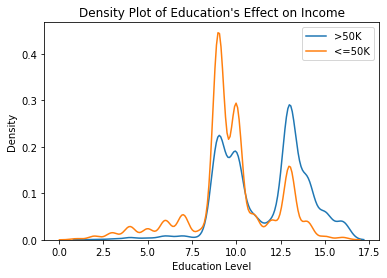

In [82]:
sns.kdeplot(df_income[df_income['income']=='>50K']['education.num'])
sns.kdeplot(df_income[df_income['income']=='<=50K']['education.num'])
plt.legend(labels=['>50K','<=50K'])
plt.title("Density Plot of Education's Effect on Income")
plt.xlabel('Education Level')
plt.show()

Similar to the above plot, this density plot examines hours worked per week's effect on income. The lower end of the graph (below 40 per week) does seem very intuitive given that part time work really shouldn't be enough to compete with a full time job, but the further end is interesting given the distances between the two density plots at 40, 50, and 60, indicating that more hours does imply more income.

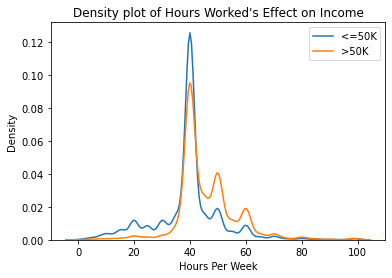

In [83]:
sns.kdeplot(df_income[df_income['income']=='<=50K']['hours.per.week'])
sns.kdeplot(df_income[df_income['income']=='>50K']['hours.per.week'])
plt.title("Density plot of Hours Worked's Effect on Income")
plt.xlabel('Hours Per Week')
plt.legend(labels=['<=50K','>50K'])
plt.show()

In [84]:
# Adjusting "native.country" column:
df_income['native.country'].loc[df_income['native.country']!='United-States'] = 'Other'

# Adjusting 'hours.per.week' column:
bins = [0,30,55,max(df_income['hours.per.week'])]
labels = ['PartTime','FullTime','Workaholic']
df_income['hours.per.week'] = pd.cut(df_income['hours.per.week'],bins=bins,labels=labels)

Finally, we come to setting up the full blown data frame which is getting the dummy variables of the data, then splitting the dataframe into train and test data. We'll be using a 70:30 split. We'll also be normalizing the numerical features.

In [85]:
def normalize_helper(column):
    return (column - column.mean())/column.std()

df_income['age'] = normalize_helper(df_income['age'])
df_income['capital.gain'] = normalize_helper(df_income['capital.gain'])
df_income['capital.loss'] = normalize_helper(df_income['capital.loss'])

df_income = pd.get_dummies(df_income,prefix_sep='.',drop_first=True)
df_income.head()

,age,education.num,capital.gain,capital.loss,workclass.Local-gov,workclass.Private,workclass.Self-emp-inc,workclass.Self-emp-not-inc,workclass.State-gov,workclass.Without-pay,...,occupation.Priv-house-serv,occupation.Prof-specialty,occupation.Protective-serv,occupation.Sales,occupation.Tech-support,occupation.Transport-moving,hours.per.week.FullTime,hours.per.week.Workaholic,native.country.United-States,income.>50K
1,3.316575,9,-0.147442,10.555639,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.184811,4,-0.147442,9.427759,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0.195064,10,-0.147442,9.427759,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
5,-0.337877,9,-0.147442,9.106214,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6,-0.033339,6,-0.147442,9.106214,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [86]:
# Train-test split with train set being 70% of the data.
X = df_income.loc[:, df_income.columns!='income.>50K']
y = df_income['income.>50K']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=12)

#### Step 2: Build and train a basic NN:

In [157]:
def fit_nn_model(act_function,kern_initializer,bias,hl_size):    
    tf.random.set_seed(12)
    model = keras.models.Sequential()

    model.add(keras.layers.Dense(units=hl_size,input_dim=X_train.shape[1],bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=hl_size,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=hl_size,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=hl_size,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=1,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation='sigmoid'))

    model.compile(optimizer='adam',loss='binary_crossentropy')
    model.fit(X_train,y_train,epochs=12,verbose=0)
    return model

model = fit_nn_model('relu','random_uniform','ones',32)

In [145]:
def get_train_accuracy(model):
    y_hat = np.concatenate(model.predict(X_train))
    y_hat = np.round(y_hat)
    confusion_matrix = pd.crosstab(y_train.values,y_hat)
    numerator = confusion_matrix[0][0]+confusion_matrix[1][1]
    denominator = numerator+confusion_matrix[0][1]+confusion_matrix[1][0]
    return numerator/denominator
print('Train error is: '+str(get_train_accuracy(model)))

Train error is: 0.8523184767678681


#### Step 3: Test your NN on the testing dataset.

In [146]:
def get_test_accuracy(model):
    y_hat = np.concatenate(model.predict(X_test))
    y_hat = np.round(y_hat)
    confusion_matrix = pd.crosstab(y_test.values,y_hat)
    numerator = confusion_matrix[0][0]+confusion_matrix[1][1]
    denominator = numerator+confusion_matrix[0][1]+confusion_matrix[1][0]
    return numerator/denominator
print('Test error is: '+str(get_test_accuracy(model)))

Test error is: 0.8529119239694994


In [147]:
model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_212 (Dense)           (None, 32)                1056      
                                                                 
 dense_213 (Dense)           (None, 32)                1056      
                                                                 
 dense_214 (Dense)           (None, 32)                1056      
                                                                 
 dense_215 (Dense)           (None, 32)                1056      
                                                                 
 dense_216 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________


## Part 2: Optimizing NN

#### Step1: Choose one hyperparameter to modify. Fix the NN structure and all other parameters, and change values only for your chosen hyperparameter. 

It should be mentioned that the established test error is 0.8529119239694994. We will be changing the activation functions. The output layer will always be sigmoid but we will be trying out tanh and selu in addition to the relu that was used in the original model.

After examining these tables, the setup which yielded the highest accuracy was with ReLU, 64 hidden layer units, a bias initializer of ones, and a kernel initializer of random uniform.

In [148]:
index_labels = ['Activation Function','HL Size','Bias Initializer','Kernal Initializer']

model_1 = fit_nn_model('relu','random_uniform','ones',32)
model_2 = fit_nn_model('tanh','random_uniform','ones',32)
model_3 = fit_nn_model('selu','random_uniform','ones',32)

test_accuracy_1 = get_test_accuracy(model_1)
test_accuracy_2 = get_test_accuracy(model_2)
test_accuracy_3 = get_test_accuracy(model_3)

pd.DataFrame({'Setup1':['ReLU','32','ones','Random Uniform'],
             'Accuracy1':test_accuracy_1,
             'Setup2':['tanh','32','ones','Random Uniform'],
             'Accuracy2':test_accuracy_2,
             'Setup3':['selu','32','ones','Random Uniform'],
             'Accuracy3':test_accuracy_3},
             index=index_labels)

,Setup1,Accuracy1,Setup2,Accuracy2,Setup3,Accuracy3
Activation Function,ReLU,0.852912,tanh,0.852028,selu,0.851365
HL Size,32,0.852912,32,0.852028,32,0.851365
Bias Initializer,ones,0.852912,ones,0.852028,ones,0.851365
Kernal Initializer,Random Uniform,0.852912,Random Uniform,0.852028,Random Uniform,0.851365


In [149]:
model_1 = fit_nn_model('relu','random_uniform','ones',32)
model_2 = fit_nn_model('relu','random_uniform','ones',16)
model_3 = fit_nn_model('relu','random_uniform','ones',64)

test_accuracy_1 = get_test_accuracy(model_1)
test_accuracy_2 = get_test_accuracy(model_2)
test_accuracy_3 = get_test_accuracy(model_3)

pd.DataFrame({'Setup1':['ReLU','32','ones','Random Uniform'],
             'Accuracy1':test_accuracy_1,
             'Setup2':['ReLU','16','ones','Random Uniform'],
             'Accuracy2':test_accuracy_2,
             'Setup3':['ReLU','64','ones','Random Uniform'],
             'Accuracy3':test_accuracy_3},
             index=index_labels)

,Setup1,Accuracy1,Setup2,Accuracy2,Setup3,Accuracy3
Activation Function,ReLU,0.852912,ReLU,0.852912,ReLU,0.856117
HL Size,32,0.852912,16,0.852912,64,0.856117
Bias Initializer,ones,0.852912,ones,0.852912,ones,0.856117
Kernal Initializer,Random Uniform,0.852912,Random Uniform,0.852912,Random Uniform,0.856117


In [150]:
model_1 = fit_nn_model('relu','random_uniform','ones',32)
model_2 = fit_nn_model('relu','random_uniform','zeros',32)
model_3 = fit_nn_model('relu','random_uniform','glorot_uniform',32)

test_accuracy_1 = get_test_accuracy(model_1)
test_accuracy_2 = get_test_accuracy(model_2)
test_accuracy_3 = get_test_accuracy(model_3)

pd.DataFrame({'Setup1':['ReLU','32','ones','Random Uniform'],
             'Accuracy1':test_accuracy_1,
             'Setup2':['ReLU','32','zeros','Random Uniform'],
             'Accuracy2':test_accuracy_2,
             'Setup3':['ReLU','32','glorot_uniform','Random Uniform'],
             'Accuracy3':test_accuracy_3},
             index=index_labels)

,Setup1,Accuracy1,Setup2,Accuracy2,Setup3,Accuracy3
Activation Function,ReLU,0.852912,ReLU,0.854017,ReLU,0.853464
HL Size,32,0.852912,32,0.854017,32,0.853464
Bias Initializer,ones,0.852912,zeros,0.854017,glorot_uniform,0.853464
Kernal Initializer,Random Uniform,0.852912,Random Uniform,0.854017,Random Uniform,0.853464


In [151]:
model_1 = fit_nn_model('relu','random_uniform','ones',32)
model_2 = fit_nn_model('relu','glorot_uniform','ones',32)
model_3 = fit_nn_model('relu','random_normal','ones',32)

test_accuracy_1 = get_test_accuracy(model_1)
test_accuracy_2 = get_test_accuracy(model_2)
test_accuracy_3 = get_test_accuracy(model_3)

pd.DataFrame({'Setup1':['ReLU','32','ones','Random Uniform'],
             'Accuracy1':test_accuracy_1,
             'Setup2':['ReLU','32','ones','Glorot Uniform'],
             'Accuracy2':test_accuracy_2,
             'Setup3':['ReLU','32','ones','Random Normal'],
             'Accuracy3':test_accuracy_3},
             index=index_labels)

,Setup1,Accuracy1,Setup2,Accuracy2,Setup3,Accuracy3
Activation Function,ReLU,0.852912,ReLU,0.854128,ReLU,0.853133
HL Size,32,0.852912,32,0.854128,32,0.853133
Bias Initializer,ones,0.852912,ones,0.854128,ones,0.853133
Kernal Initializer,Random Uniform,0.852912,Glorot Uniform,0.854128,Random Normal,0.853133


#### Step 3: After completing step 2, choose a model setup that returns the best accuracy and use it as a 'base' model. In deep learning frameworks there is a number of new methods that help to increase the training speed, accuracy, etc.. Find and try at least 4 different methods.

First I tried early stopping which diminished the test error but only by about half a percent. The benefit of it was a much shorter runtime.

Next came reducing learning rate upon a plateau, which appears to have changed literally nothing. Both the runtime and the accuracy remained the same.

Following that, batch size was tried (batch of 120) which retained identical accuracy to the original model but it cut down runtime by a quarter. It wasn't quite as fast as using the early stopping. So either would be considered better than the original, but it depends how much you need that extra bit of accuracy.

Lastly, we arrive at TerminateOnNaN, another callback from the keras library which, while not practical at this stage of development could be WILDLY important when experimenting early on. Naturally, this has the same runtime and accuracy as the base model.

In [159]:
%timeit model = fit_nn_model('relu','random_uniform','ones',64)
get_test_accuracy(model)

11.3 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


0.8529119239694994

In [156]:
def fit_nn_model(act_function,kern_initializer,bias,hl_size):    
    tf.random.set_seed(12)
    callback = keras.callbacks.EarlyStopping(monitor='loss')
    model = keras.models.Sequential()

    model.add(keras.layers.Dense(units=hl_size,input_dim=X_train.shape[1],bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=hl_size,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=hl_size,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=hl_size,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=1,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation='sigmoid'))

    model.compile(optimizer='adam',loss='binary_crossentropy')
    model.fit(X_train,y_train,epochs=12,verbose=0,callbacks=[callback])
    return model

%timeit model = fit_nn_model('relu','random_uniform','ones',64)
get_test_accuracy(model)

2.31 s ± 52.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


0.8463918665045861

In [162]:
def fit_nn_model(act_function,kern_initializer,bias,hl_size):    
    tf.random.set_seed(12)
    model = keras.models.Sequential()

    model.add(keras.layers.Dense(units=hl_size,input_dim=X_train.shape[1],bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=hl_size,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=hl_size,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=hl_size,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=1,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation='sigmoid'))

    model.compile(optimizer='adam',loss='binary_crossentropy')
    model.fit(X_train,y_train,epochs=12,verbose=0,batch_size=120)
    return model

%timeit model = fit_nn_model('relu','random_uniform','ones',64)
get_test_accuracy(model)

3.95 s ± 42.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


0.8529119239694994

In [164]:
def fit_nn_model(act_function,kern_initializer,bias,hl_size):    
    tf.random.set_seed(12)
    callback = keras.callbacks.TerminateOnNaN()
    model = keras.models.Sequential()

    model.add(keras.layers.Dense(units=hl_size,input_dim=X_train.shape[1],bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=hl_size,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=hl_size,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=hl_size,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation=act_function))
    model.add(keras.layers.Dense(units=1,input_dim=hl_size,bias_initializer=bias,
                                 kernel_initializer=kern_initializer,activation='sigmoid'))

    model.compile(optimizer='adam',loss='binary_crossentropy')
    model.fit(X_train,y_train,epochs=12,verbose=0)
    return model

%timeit model = fit_nn_model('relu','random_uniform','ones',64)
get_test_accuracy(model)

11.4 s ± 59.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


0.8529119239694994

## Part 3: Building a CNN

#### Step 1: Load, preprocess, and analyze the dataset and make it ready for training.

In [2]:
(X_train,y_train),(X_test,y_test) = keras.datasets.fashion_mnist.load_data()

As explained in the assignment prompt, this is a dataset of 28x28 grayscale images. The labels are numbers between 0 and 9, each representing a category of clothes. The table below illustrates what number corresponds to what item of clothing. 

The data is loaded in with a train-test split of 60,000 to 10,000 which is about an 85% split.

In [3]:
label_list = [0,1,2,3,4,5,6,7,8,9]
description_list = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
pd.DataFrame(description_list,label_list,columns=['Description'])

,Description
0,T-shirt
1,Trouser
2,Pullover
3,Dress
4,Coat
5,Sandal
6,Shirt
7,Sneaker
8,Bag
9,Ankle boot


## Build and Train a Basic CNN (with max 3 hidden layers). 

## Decide your CNN architecture: 

 - How many input neurons are there?
 
 - What activation function will you choose?
 
 - What is the number of hidden layers? (1, 2, or 3)
 
 - What is the kernel size, number of filters, strides, padding, etc.?
 
 - What activation function is used for the hidden and output layer?

In [215]:
tf.random.set_seed(12)

act_func = 'relu'
kernel_initializer = 'glorot_uniform'
dropout_rate = 0.12
optimizer = 'adam'

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32,(4,4),padding='same',activation=act_func,
                              kernel_initializer=kernel_initializer,input_shape=(28,28,1)))
model.add(keras.layers.MaxPooling2D(3,3))
model.add(keras.layers.Conv2D(64,(3,3),padding='same',activation=act_func,
                              kernel_initializer=kernel_initializer))
model.add(keras.layers.AveragePooling2D(3,3))
model.add(keras.layers.Conv2D(32,(3,3),padding='same',activation=act_func,
                              kernel_initializer=kernel_initializer))
model.add(keras.layers.Conv2D(32,(3,3),padding='same',activation=act_func,
                              kernel_initializer=kernel_initializer))
model.add(keras.layers.MaxPooling2D(3,3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation=act_func))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(10,activation='softmax'))

model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_0 = model.fit(X_train,y_train,epochs=7,validation_data=(X_test,y_test),verbose=1)

Epoch 1/7
1875/1875 [==============================] - 58s 26ms/step - loss: 0.5131 - accuracy: 0.8164 - val_loss: 0.3837 - val_accuracy: 0.8604
Epoch 2/7
1875/1875 [==============================] - 29s 15ms/step - loss: 0.3213 - accuracy: 0.8843 - val_loss: 0.3182 - val_accuracy: 0.8871
Epoch 3/7
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2844 - accuracy: 0.8969 - val_loss: 0.3194 - val_accuracy: 0.8890
Epoch 4/7
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2614 - accuracy: 0.9035 - val_loss: 0.3026 - val_accuracy: 0.8917
Epoch 5/7
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2448 - accuracy: 0.9094 - val_loss: 0.3160 - val_accuracy: 0.8919
Epoch 6/7
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2305 - accuracy: 0.9140 - val_loss: 0.3065 - val_accuracy: 0.8936
Epoch 7/7
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2172 - accuracy: 0.9197 - val_loss: 0.2635 - val_ac

In [132]:
model.summary()

Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_367 (Conv2D)         (None, 28, 28, 32)        544       
                                                                 
 max_pooling2d_206 (MaxPooli  (None, 9, 9, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_368 (Conv2D)         (None, 9, 9, 64)          18496     
                                                                 
 average_pooling2d_14 (Avera  (None, 3, 3, 64)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_369 (Conv2D)         (None, 3, 3, 32)          18464     
                                                                 
 conv2d_370 (Conv2D)         (None, 3, 3, 32)       

## Add all the improvement methods that you tried for "Part III Step 3" of this assignment, that are applicable to CNN architecture (e.g. earlystopping).

Only batch_size and EarlyStopping were implemented here since TerminateOnNaN wouldn't even apply here, just like in the last one. Therefore, I won't even bother typing it into the code.

In [133]:
tf.random.set_seed(12)
model = keras.models.Sequential()
callback = keras.callbacks.EarlyStopping(monitor='loss')
model.add(keras.layers.Conv2D(32,(4,4),padding='same',activation=act_func,
                              kernel_initializer=kernel_initializer,input_shape=(28,28,1)))
model.add(keras.layers.MaxPooling2D(3,3))
model.add(keras.layers.Conv2D(64,(3,3),padding='same',activation=act_func,
                              kernel_initializer=kernel_initializer))
model.add(keras.layers.AveragePooling2D(3,3))
model.add(keras.layers.Conv2D(32,(3,3),padding='same',activation=act_func,
                              kernel_initializer=kernel_initializer))
model.add(keras.layers.Conv2D(32,(3,3),padding='same',activation=act_func,
                              kernel_initializer=kernel_initializer))
model.add(keras.layers.MaxPooling2D(3,3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation=act_func))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(10,activation='softmax'))

model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_1 = model.fit(X_train,y_train,epochs=7,validation_data=(X_test,y_test),
                    batch_size=120,callbacks=[callback],verbose=1)

Epoch 1/7
500/500 [==============================] - 24s 47ms/step - loss: 0.6538 - accuracy: 0.7750 - val_loss: 0.4335 - val_accuracy: 0.8386
Epoch 2/7
500/500 [==============================] - 23s 46ms/step - loss: 0.3691 - accuracy: 0.8663 - val_loss: 0.3413 - val_accuracy: 0.8760


The graphs below are for the original model, without EarlyStopping and a different batch size. This is solely due to EarlyStopping making the model stop after only 2 epochs which makes for an uninteresting graph. 

The loss graph (the detail the EarlyStopping monitors) illustrates why it stops after 2 epochs, there is quite the distinct elbow, even though the loss does keep going down consistently. Furthermore, the test loss even goes up after the second epoch.

Altering the batch_size argument in the fit call is primarily for internal arguments. The default argument is 32, but giving an argument of 120 is well within reason. A smaller batch would have made the model fit more quickly, but the runtime (sometime around 3.5 minutes), while inconvenient, is definitely tolerable. So we can handle a larger batch size for a little bit more accuracy. All the same, EarlyStopping makes this a moot point.

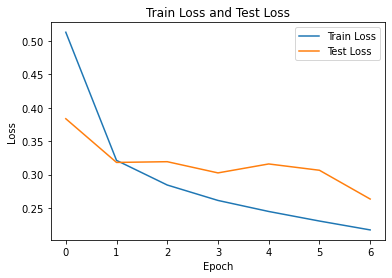

In [135]:
plt.plot(history_0.history['loss'])
plt.plot(history_0.history['val_loss'])
plt.title('Train Loss and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss','Test Loss'])
plt.show()

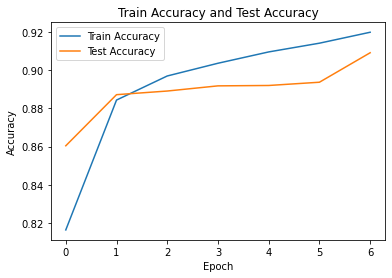

In [136]:
plt.plot(history_0.history['accuracy'])
plt.plot(history_0.history['val_accuracy'])
plt.title('Train Accuracy and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy','Test Accuracy'])
plt.show()

## Test your NN on the testing dataset. It shows the effectiveness of your model's generalization power gained by learning.

As the validation data was made to be the testing data, each epoch prints out the test accuracy.

## Part IV: Optimizing CNN + Data Augmentation

## Based on your CNN model defined in Part III, play with various hyperparameters and different tools to increase the accuracy. Try various setups and draw conclusions.

### Step 1: Choose one hyperparameter to modify. Fix the CNN structure and all other parameters, and change values only for your chosen hyperparameter. Provide the results in a form of a table below.

In [138]:
def fit_cnn_model(optimizer,act_func,dropout_rate,kernel_initializer):
    tf.random.set_seed(12)
    callback = keras.callbacks.EarlyStopping(monitor='loss')
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32,(4,4),padding='same',activation=act_func,
                                  kernel_initializer=kernel_initializer,input_shape=(28,28,1)))
    model.add(keras.layers.MaxPooling2D(3,3))
    model.add(keras.layers.Conv2D(64,(3,3),padding='same',activation=act_func,
                                  kernel_initializer=kernel_initializer))
    model.add(keras.layers.AveragePooling2D(3,3))
    model.add(keras.layers.Conv2D(32,(3,3),padding='same',activation=act_func,
                                  kernel_initializer=kernel_initializer))
    model.add(keras.layers.Conv2D(32,(3,3),padding='same',activation=act_func,
                                  kernel_initializer=kernel_initializer))
    model.add(keras.layers.MaxPooling2D(3,3))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128,activation=act_func))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(10,activation='softmax'))

    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(X_train,y_train,epochs=7,validation_data=(X_test,y_test),
                        callbacks=[callback],batch_size=120,verbose=0)
    
    return history

In [139]:
index_labels = ['Optimizer','Activation Function','Dropout Rate','Kernal Initializer']

optim_history_1 = fit_cnn_model('adam','relu',0.12,'glorot_uniform')
optim_history_2 = fit_cnn_model('sgd','relu',0.12,'glorot_uniform')
optim_history_3 = fit_cnn_model('adagrad','relu',0.12,'glorot_uniform')

test_accuracy_1 = optim_history_1.history['accuracy'][1]
test_accuracy_2 = optim_history_2.history['accuracy'][1]
test_accuracy_3 = optim_history_3.history['accuracy'][1]

pd.DataFrame({'Setup1':['adam','relu','0.12','glorot_uniform'],
             'Accuracy1':test_accuracy_1,
             'Setup2':['sgd','relu','0.12','glorot_uniform'],
             'Accuracy2':test_accuracy_2,
             'Setup3':['adagrad','relu','0.12','glorot_uniform'],
             'Accuracy3':test_accuracy_3},
             index=index_labels)

,Setup1,Accuracy1,Setup2,Accuracy2,Setup3,Accuracy3
Optimizer,adam,0.866267,sgd,0.822867,adagrad,0.752783
Activation Function,relu,0.866267,relu,0.822867,relu,0.752783
Dropout Rate,0.12,0.866267,0.12,0.822867,0.12,0.752783
Kernal Initializer,glorot_uniform,0.866267,glorot_uniform,0.822867,glorot_uniform,0.752783


Given how much EarlyStopping limits the number of epochs, we arrive at sort of uninteresting graphs, but they're nice for comparing the accuracies of each optimizer. However, the optimizers have quite similar accuracies so visual comparisons aren't very fruitful.

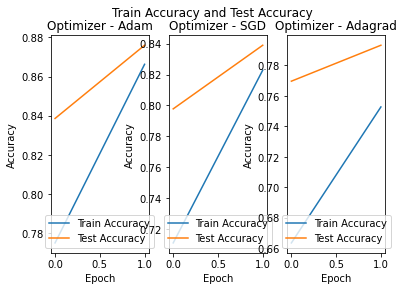

In [151]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3)
plt.suptitle('Train Accuracy and Test Accuracy')

ax1.plot(optim_history_1.history['accuracy'])
ax1.plot(optim_history_1.history['val_accuracy'])
ax1.set_title('Optimizer - Adam')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train Accuracy','Test Accuracy'],loc='lower center')

ax2.plot(optim_history_2.history['accuracy'])
ax2.plot(optim_history_2.history['val_accuracy'])
ax2.set_title('Optimizer - SGD')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(['Train Accuracy','Test Accuracy'],loc='lower center')

ax3.plot(optim_history_3.history['accuracy'])
ax3.plot(optim_history_3.history['val_accuracy'])
ax3.set_title('Optimizer - Adagrad')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend(['Train Accuracy','Test Accuracy'],loc='lower center')

plt.show()

In [140]:
index_labels = ['Optimizer','Activation Function','Dropout Rate','Kernal Initializer']

activation_history_1 = fit_cnn_model('adam','relu',0.12,'glorot_uniform')
activation_history_2 = fit_cnn_model('adam','tanh',0.12,'glorot_uniform')
activation_history_3 = fit_cnn_model('adam','softplus',0.12,'glorot_uniform')

test_accuracy_1 = activation_history_1.history['accuracy'][1]
test_accuracy_2 = activation_history_2.history['accuracy'][1]
test_accuracy_3 = activation_history_3.history['accuracy'][1]

pd.DataFrame({'Setup1':['adam','relu','0.12','glorot_uniform'],
             'Accuracy1':test_accuracy_1,
             'Setup2':['adam','tanh','0.12','glorot_uniform'],
             'Accuracy2':test_accuracy_2,
             'Setup3':['adam','softplus','0.12','glorot_uniform'],
             'Accuracy3':test_accuracy_3},
             index=index_labels)

,Setup1,Accuracy1,Setup2,Accuracy2,Setup3,Accuracy3
Optimizer,adam,0.866267,adam,0.860317,adam,0.870783
Activation Function,relu,0.866267,tanh,0.860317,softplus,0.870783
Dropout Rate,0.12,0.866267,0.12,0.860317,0.12,0.870783
Kernal Initializer,glorot_uniform,0.866267,glorot_uniform,0.860317,glorot_uniform,0.870783


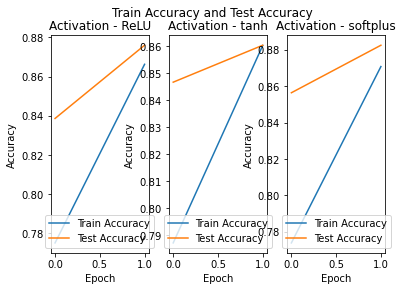

In [152]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3)
plt.suptitle('Train Accuracy and Test Accuracy')

ax1.plot(activation_history_1.history['accuracy'])
ax1.plot(activation_history_1.history['val_accuracy'])
ax1.set_title('Activation - ReLU')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train Accuracy','Test Accuracy'],loc='lower center')

ax2.plot(activation_history_2.history['accuracy'])
ax2.plot(activation_history_2.history['val_accuracy'])
ax2.set_title('Activation - tanh')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(['Train Accuracy','Test Accuracy'],loc='lower center')

ax3.plot(activation_history_3.history['accuracy'])
ax3.plot(activation_history_3.history['val_accuracy'])
ax3.set_title('Activation - softplus')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend(['Train Accuracy','Test Accuracy'],loc='lower center')

plt.show()

In [141]:
index_labels = ['Optimizer','Activation Function','Dropout Rate','Kernal Initializer']

dropout_history_1 = fit_cnn_model('adam','relu',0.06,'glorot_uniform')
dropout_history_2 = fit_cnn_model('adam','relu',0.24,'glorot_uniform')
dropout_history_3 = fit_cnn_model('adam','relu',0.36,'glorot_uniform')

test_accuracy_1 = dropout_history_1.history['accuracy'][1]
test_accuracy_2 = dropout_history_2.history['accuracy'][1]
test_accuracy_3 = dropout_history_3.history['accuracy'][1]

pd.DataFrame({'Setup1':['adam','relu','0.06','glorot_uniform'],
             'Accuracy1':test_accuracy_1,
             'Setup2':['adam','relu','0.24','glorot_uniform'],
             'Accuracy2':test_accuracy_2,
             'Setup3':['adam','relu','0.36','glorot_uniform'],
             'Accuracy3':test_accuracy_3},
             index=index_labels)

,Setup1,Accuracy1,Setup2,Accuracy2,Setup3,Accuracy3
Optimizer,adam,0.8752,adam,0.866233,adam,0.8596
Activation Function,relu,0.8752,relu,0.866233,relu,0.8596
Dropout Rate,0.06,0.8752,0.24,0.866233,0.36,0.8596
Kernal Initializer,glorot_uniform,0.8752,glorot_uniform,0.866233,glorot_uniform,0.8596


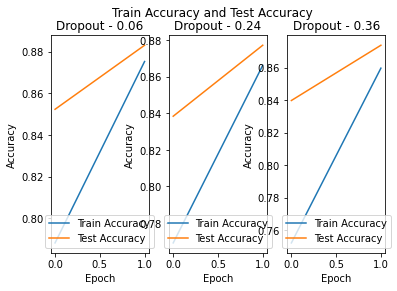

In [153]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3)
plt.suptitle('Train Accuracy and Test Accuracy')

ax1.plot(dropout_history_1.history['accuracy'])
ax1.plot(dropout_history_1.history['val_accuracy'])
ax1.set_title('Dropout - 0.06')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train Accuracy','Test Accuracy'],loc='lower center')

ax2.plot(dropout_history_2.history['accuracy'])
ax2.plot(dropout_history_2.history['val_accuracy'])
ax2.set_title('Dropout - 0.24')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(['Train Accuracy','Test Accuracy'],loc='lower center')

ax3.plot(dropout_history_3.history['accuracy'])
ax3.plot(dropout_history_3.history['val_accuracy'])
ax3.set_title('Dropout - 0.36')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend(['Train Accuracy','Test Accuracy'],loc='lower center')

plt.show()

In [142]:
index_labels = ['Optimizer','Activation Function','Dropout Rate','Kernal Initializer']

kernel_history_1 = fit_cnn_model('adam','relu',0.12,'random_uniform')
kernel_history_2 = fit_cnn_model('adam','relu',0.12,'ones')
kernel_history_3 = fit_cnn_model('adam','relu',0.12,'zeros')

test_accuracy_1 = kernel_history_1.history['accuracy'][1]
test_accuracy_2 = kernel_history_2.history['accuracy'][1]
test_accuracy_3 = kernel_history_3.history['accuracy'][1]

pd.DataFrame({'Setup1':['adam','relu','0.12','random_uniform'],
             'Accuracy1':test_accuracy_1,
             'Setup2':['adam','relu','0.12','ones'],
             'Accuracy2':test_accuracy_2,
             'Setup3':['adam','relu','0.12','zeros'],
             'Accuracy3':test_accuracy_3},
             index=index_labels)

,Setup1,Accuracy1,Setup2,Accuracy2,Setup3,Accuracy3
Optimizer,adam,0.868467,adam,0.098217,adam,0.0987
Activation Function,relu,0.868467,relu,0.098217,relu,0.0987
Dropout Rate,0.12,0.868467,0.12,0.098217,0.12,0.0987
Kernal Initializer,random_uniform,0.868467,ones,0.098217,zeros,0.0987


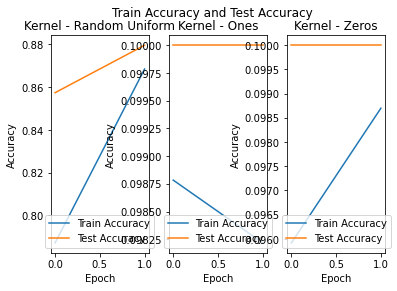

In [154]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3)
plt.suptitle('Train Accuracy and Test Accuracy')

ax1.plot(kernel_history_1.history['accuracy'])
ax1.plot(kernel_history_1.history['val_accuracy'])
ax1.set_title('Kernel - Random Uniform')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train Accuracy','Test Accuracy'],loc='lower center')

ax2.plot(kernel_history_2.history['accuracy'])
ax2.plot(kernel_history_2.history['val_accuracy'])
ax2.set_title('Kernel - Ones')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(['Train Accuracy','Test Accuracy'],loc='lower center')

ax3.plot(kernel_history_3.history['accuracy'])
ax3.plot(kernel_history_3.history['val_accuracy'])
ax3.set_title('Kernel - Zeros')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend(['Train Accuracy','Test Accuracy'],loc='lower center')

plt.show()

The motivation for each of these changes was largely by trial and error. For optimizers, I had tried quite a few when developing the inital model and found adam to be the best so I'm not very surprised when it came out on top.

With activation functions, I didn't expect softplus to outperform relu due to its prevelance in award winning CNN architectures such as AlexNet. But alas, softplus is the winner, albeit with fairly narrow margins.

A dropout of 0.12 didn't seem to change a ton in my experimentations that won't be covered in this report, but the table suggests that a smaller dropout rate may yield a little bit better results.

Finally, we arrive to the one which has the largest disparity. The kernel initializers of zeros and ones were absolutely abyssmal. If given more time to run through more epochs, they may perform better, but even at this point they should be disqualified when compared to glorot_uniform and random_uniform given their supremely improved performance off the bat.

The result of this block of code here is the rotation of all of the images in the dataset. The called for quadrupling of the dataset (going from 60k samples to 240k samples) is achieved simply by rotating all entries in the dataset by 90 degrees, then again 180 degrees, and yet again by 270 degrees. The expanded y_train array is done simply by repeating the original y_train 4 times.

(240000, 28, 28)
(240000,)


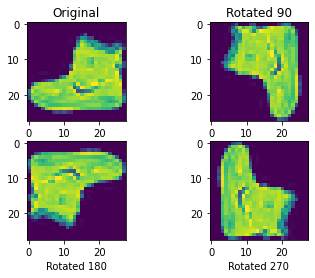

In [279]:
X_train_90 = np.rot90(X_train,axes=(1,2))
X_train_180 = np.rot90(X_train,axes=(1,2),k=2)
X_train_270 = np.rot90(X_train,axes=(1,2),k=3)

train_arrays = (X_train,X_train_90,X_train_180,X_train_270)
X_train_big = np.concatenate(train_arrays)

y_train_big = np.repeat(y_train,repeats=4)

print(X_train_big.shape)
print(y_train_big.shape)

fig,axs = plt.subplots(2,2)

axs[0,0].imshow(X_train[0])
axs[0,0].set_title('Original')

axs[0,1].imshow(X_train_90[0])
axs[0,1].set_title('Rotated 90')

axs[1,0].imshow(X_train_180[0])
axs[1,0].set_xlabel('Rotated 180')

axs[1,1].imshow(X_train_270[0])
axs[1,1].set_xlabel('Rotated 270')
plt.show()

The expanded dataset tanked the accuracy of the model. I can assure you that nothing within the model changed in the slightest: I literally copied and pasted the code from the original model from Part III. The only details changed were the training data and their associated labels.

However, it does stand to reason that augmenting the data in this way makes for a far more generalizable model, where the model picks up on details that humans are more capable of observing, such as realizing that symmetrical images of the same object are very obviously still the same object.

In [269]:
tf.random.set_seed(12)

act_func = 'relu'
kernel_initializer = 'glorot_uniform'
dropout_rate = 0.12
optimizer = 'adam'

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32,(4,4),padding='same',activation=act_func,
                              kernel_initializer=kernel_initializer,input_shape=(28,28,1)))
model.add(keras.layers.MaxPooling2D(3,3))
model.add(keras.layers.Conv2D(64,(3,3),padding='same',activation=act_func,
                              kernel_initializer=kernel_initializer))
model.add(keras.layers.AveragePooling2D(3,3))
model.add(keras.layers.Conv2D(32,(3,3),padding='same',activation=act_func,
                              kernel_initializer=kernel_initializer))
model.add(keras.layers.Conv2D(32,(3,3),padding='same',activation=act_func,
                              kernel_initializer=kernel_initializer))
model.add(keras.layers.MaxPooling2D(3,3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation=act_func))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(10,activation='softmax'))

model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_aug = model.fit(X_train_big,y_train_big,epochs=7,validation_data=(X_test,y_test),verbose=1)

Epoch 1/7
7500/7500 [==============================] - 150s 20ms/step - loss: 2.3068 - accuracy: 0.1004 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/7
7500/7500 [==============================] - 146s 19ms/step - loss: 2.3028 - accuracy: 0.1009 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/7
7500/7500 [==============================] - 146s 19ms/step - loss: 2.3027 - accuracy: 0.1002 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 4/7
7500/7500 [==============================] - 145s 19ms/step - loss: 2.3027 - accuracy: 0.0994 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 5/7
7500/7500 [==============================] - 145s 19ms/step - loss: 2.3027 - accuracy: 0.1004 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 6/7
7500/7500 [==============================] - 142s 19ms/step - loss: 2.3027 - accuracy: 0.0997 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 7/7
7500/7500 [==============================] - 142s 19ms/step - loss: 2.3028 - accuracy: 0.0992 - val_loss: 2.3027 -